## Markov Chain Monte Carlo Methods

Here I am going to motivate and demonstrate the mathematical reasoning why the Markov Chain Monte Carlo (MCMC) method of sampling complex distributions works.  As the name suggests, the MCMC method is dependent on the mathematics of Markov chains, which will be our starting point. After the basics are established, we will see if there is ways of crafting Markov chains such that we sample from a distribution of our choosing.  Lastly, we'll generalize the result which gives us the MCMC method.  

### Markov Chains - Basics

Markov chains are an expression of when probability distributions of a random variable $z$ change dependent on the previous and only the previous state of $z$.  This can be viewed as a series of steps $n = \{1,2,...,N\}$ where the probability distribution for step $m$ to sample variable $z_m$ depends on previous state of the $m-1$ step, $z_{m-1}$, mathematically this is expressed as

$p(z_m) = \sum_{z_{m-1}} p(z_{m-1})Q(z_m|z_{m-1})$

where

$\sum_z Q(z|z') = 1$.

After a series of $n$ steps, the distribution of the $z$ variable is sampled from the sum of all possible histories of the sequence of observations $\{z_0,z_1,...,z_{n-1}\}$ probabilistically weighted for each possible path.

$p^{(n)}(z) = \sum_{z_1}...\sum_{z_n} Q(z|z_n)Q(z_n|z_{n-1})...Q(z_2|z_1)p^{(0)}(z_1)$

We can simplify this expression in terms of matrix multiplication with, 

$Q(z_i|z_j) = Q_{i,j} \rightarrow 0 \leq Q_{i,j} \leq 1$

the expression

$ p^{(n)}_z = \sum_n \sum_{n-1}...\sum_1 Q_{z,n}Q_{n,n-1}...Q_{2,1}p^{(0)}_1 $

simplifies to

${\bf p}^{(n)} = {\bf Q}^n {\bf p}^{(0)}$

where the $z$-th component of the vector ${\bf p}$ is $p(z)$, and the $ij$ component of the transition matrix ${\bf Q}$ being $Q(z_i|z_j)$. 

Diagonalizing this transition matrix allows identification of some interesting properties.  Let us express the diagonalized version of $Q$ as the following

${\bf Q} = {\bf U} {\bf \Lambda}{\bf U^{-1}}$

After $n$ applications of the transition matrix in the diagonalized form and expressing our initial distribution vector ${\bf p}^{(0)}$ in the eigenvector basis of the transition matrix, our $n$th step distribution can be represented as

${\bf p}^{(0)} = \sum_i \alpha_i {\bf u}_i =  {\bf U} {\bf \alpha} \rightarrow {\bf \alpha} = {\bf U}^{-1} {\bf p}^{(0)}$

${\bf p}^{(n)} = \sum_i \alpha_i  {\bf U} {\bf \Lambda^n}{\bf U}^{-1}{\bf u}_i$

${\bf p}^{(n)} = \sum_i \alpha_i  \lambda_i^n {\bf u}_i$

where $\lambda_i^n$ is the $i$-th eigenvalue of the transition matrix ${\bf Q}$ and ${\bf u}_i$ being the associated eigenvector.  If we are sure that all values of the transition matrix satisfy $0 \leq Q_{ij} \leq 1$ than we can impose from the Perron-Frobenius theorem, which allows us to order the eigenvalues as, 

$\lambda_1 = 1 \geq \lambda_2 \geq \lambda_k \geq 0$

such that

${\bf p}^{(n)} = \alpha_1 {\bf u}_1 + \alpha_2 \lambda_2^n {\bf u}_2 +...+\alpha_k \lambda_k^n {\bf u}_k$, $\lambda_k^n \rightarrow 0$ as $n \rightarrow \infty$

thus the limiting form of the distribution vector ${\bf p}$ is given by

${\bf p}^{(\infty)} = \alpha_1 {\bf u}_1$

because this eigenvector is associated with the largest eigenvalue $1$ it can be seen that the limiting state is a stable one, ie

$p^*(z) = \sum_{z'} p^*(z')Q(z|z')$

such that $p^*(z) = \alpha_1 {\bf u}_{1,z}$.  Furthermore we can use $\sum_z Q(z|z') = 1$ to find that the stable state must also satisfy the following

$\sum_z p^*(z)Q(z'|z) = p^*(z') \sum_z Q(z|z') = \sum_z Q(z|z')p^*(z')$

if the equality is true for each $z$ value and not only the sum, then it is said that the steady state is one of detailed balance which is defined by the equation

$p^*(z)Q(z'|z) = p^*(z')Q(z|z')$

Thus we can conclude that distributions that satisfy detailed balance will be a steady state distribution which any initial distribution under successive application of the transition matrix will ultimately end in.  A property known as ergodicity. Let us see this in action in the coding section below.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# make a 2x2 transition Q matrix
Q = np.array([[0.8,0.2],[0.01,0.99]])
# randomly initialize a 2x1 distribution vector
p_0 = np.array([[0.83],[0.17]])

# find the eigensystem
lambdas, U = np.linalg.eig(Q)
print("---EigenSystem---")
print(lambdas,U)

# finding the inverse U
U_inv = np.linalg.inv(U)

# compute the eigenvector decompistion alphas
alphas = U_inv.dot(p_0)

# find the steady state p vector
p_infty = alphas[1]*U[:,1]
print("---Steady State P-vector---")
print(p_infty)

# and to show we get the same thing through direct application
# we loop over repeated application of the transition matrix
y = p_0
for n in range(2000):
    y = np.matmul(Q,y)

print("---Direct Application---")
print(y)

---EigenSystem---
(array([ 0.79,  1.  ]), array([[-0.99875234, -0.70710678],
       [ 0.04993762, -0.70710678]]))
---Steady State P-vector---
[ 0.20142857  0.20142857]
---Direct Application---
[[ 0.20142857]
 [ 0.20142857]]


Above you can see that the steady state distribution as found from eigen-decompisition is equivalent
 to repeated application of the transition matrix.  This now allows us to look at the next required step to understand MCMC, how to does one simulate a Markov chain?

## Sampling a Markov Chain

In order to simulate a Markov chain, we will want to generate a sequence of $N$ observations of states $Z=\{z_0,z_1,...,z_N\}$ where each $z_i$ can be in any of the possible states, $S=\{s_1,s_2,...,s_M\}$, of the Markov process. In order to correctly simulate a Markov chain we must enforce that for step $z_i$ that the next step must be sampled from $Q(z_{i+1}|z_i)$.  Sampling from a generic $Q(z_{i+1}|z_i)$ can be done via a technique called rejection sampling.  The rejection sampling algorithm is accomplished via selecting a trial transition state $z'$ from a proposal distribution $g(z'|z_i)$ where $g(z'|z_i)$ must have the same support as $Q(z'|z_i)$. After selection of $z'$ we evaluate $Q(z'|z_i)$ and choose a random number $z''$ uniformly over the range $0$ to $M g(z'|z_i)$ with $M$ chosen such that $M g(z'|z_i) \geq Q(z'|z_i)$.  We accept the transition $z_{i+1}=z'$ if $z'' \leq Q(z'|z_i)$ and reject the sample and return to the step of sampling $z'$ until we find a state that is accepted. This works because the distribution of the sample will be the same as the probability of all accepted states, which is given by

$p(\hbox{accept } z') \propto g(z'|z_i) \frac{Q(z'|z_i)}{M g(z'|z_i)} = \frac{1}{M} Q(z'|z_i)$ 

Let us simulate a Markov chain in this way below.

In [3]:
# choose a 2x2 transition Q matrix to sample
Q = np.array([[0.8,0.2],[0.5,0.5]])

# choose a random initial state
Z = [0]

#loop through state transitions using the
#rejection method until we collect 10,000
#samples of the Markov chain
MAX_OBS = 10000
num_states = Q.shape[0]

while len(Z) <= MAX_OBS:
    #because our transition matrix has a finite
    #number of states to access from any state
    #our proposal distribution will be a uniform one
    #g(z'|z_i) = uniform(0,1)
    trial = np.random.randint(0,num_states)
    #because g is uniform we can set M = 1
    # and the M g > Q for all z',z pairs.
    #For every trial value z' we choose a 
    #random number between 0 and M g(z'|z_i) = 1
    acceptor = np.random.random()
    #we accept the new state if this value is less
    #than the probablity of the suggested transition
    if acceptor <= Q[Z[-1],trial]:
        Z.append(trial)
    #else we return to attempt a new trial transtion

In [4]:
# to check we've simulated the transitions correctly
# lets find all pairs of transitions from our sequence
t_pairs = np.array( [Z[i:i+2] for i in range(len(Z)-1)] )

#count the number of times it was in state 0 and 1
total_0states = float(np.sum( [x[0]==0 for x in t_pairs] ))
total_1states = float(np.sum( [x[0]==1 for x in t_pairs] ))
#count the number of transitions from 0->0, 0->1,1->0, and 1->1
t00 = np.sum( [ (x[0]==0) and (x[1]==0) for x in t_pairs] )
t01 = np.sum( [ (x[0]==0) and (x[1]==1) for x in t_pairs] )
t10 = np.sum( [ (x[0]==1) and (x[1]==0) for x in t_pairs] )
t11 = np.sum( [ (x[0]==1) and (x[1]==1) for x in t_pairs] )

#compute the empirical Q matrix rounded to the second decimal place
print(np.round([[t00/total_0states,t01/total_0states],[t10/total_1states,t11/total_1states]],2))

[[ 0.8   0.2 ]
 [ 0.51  0.49]]


[ 0.71572843  0.28427157]


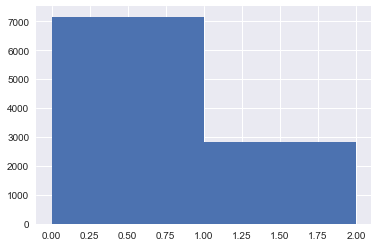

In [5]:
# producing the final state sampling distribution
bin_counts=plt.hist(Z,bins=range(3))
print(bin_counts[0]/len(Z))

## Markov Chains To Sample a Distribution

So now that we know how to sample from a Markov chain, the question arrises, can we craft a transition matrix $Q(z|z')$ such that after enough steps, we will be sampling from a stable distribution of our choosing $\pi(z)$? If $\pi(z)$ is our stable distribution then, it should be a distribution that satisfies detailed balance

$\pi(z')Q(z|z') = \pi(z)Q(z'|z)$

which can be re-written as

$\frac{\pi(z')}{\pi(z)} = \frac{Q(z'|z)}{Q(z|z')}$

Metropolis's insight is that $Q(z|z') = \hbox{min}\left(1,\frac{\pi(z)}{\pi(z')}\right)$ would satisfy this equation as demonstrated below

Case 1:

$\pi(z)>\pi(z')$

$\frac{Q(z'|z)}{Q(z|z')} = \frac{\pi(z')/\pi(z)}{1} = \frac{\pi(z')}{\pi(z)}$

Case 2:

$\pi(z)<\pi(z')$

$\frac{Q(z'|z)}{Q(z|z')} = \frac{1}{\pi(z)/\pi(z')} = \frac{\pi(z')}{\pi(z)}$


Thus if we sample from this transition matrix, after enough samples (what classifies enough depends on $\pi(z)$) the samples should start to be sampled from $\pi(z)$.  This "enough" concept is known as burn in and is typically found by empirically viewing when the distribution starts to stabilize after dropping some number of the initially sampled values. One might notice that to correctly sample $Q(z|z')$ your proposal distribution $g(z|z')$ must have the same support as $\pi(z)$ which could potentially be very large. Lets try this out.

In [6]:
# our discrete probablity distribution 
# we want to sample from
p = np.array([0.2,0.4,0.3,0.1])

# hold the samples with the initial sample set
Z = [0]
# use g = Uniform(0,3) as the proposal distribution
# which has the same support as the desired distro
while len(Z) <= 100000:
    # select the trial
    trial = np.random.randint(0,len(p))
    state = Z[-1]
    #use rejection sampling to drive toward 
    #the distribution we want
    if np.random.random() <= (p[trial])/(p[state]):
        Z.append(trial)

[ 0.23453031  0.33195646  0.30052964  0.13298359]


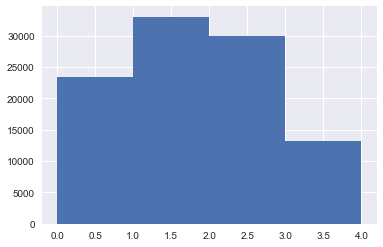

In [7]:
#dropping the first 500 samples as the burn in samples
burnedin = Z[500:]
bin_counts=plt.hist(burnedin,bins=range(len(p)+1))
#verify we get samples that approximate the discrete distribution
print(bin_counts[0]/np.sum(bin_counts[0]))

pretty close to the designed probably distribution

## Metropolis-Hastings Algorithm

The Metropolis algorithm allows us to sample from a desired distribution, but the fact that the proposal distribution has to have the same support as the distribution means or proposal distribution could be just as difficult to sample as the original $\pi(z)$ distribution.  The Metropolis-Hastings algorithm addresses this problem by bringing the proposal distribution of the rejection method, $g(z|z')$ that will be used as a factor in the transition probability via

$Q(z|z') = g(z|z')A(z|z')$

where $A(z|z')$ is called the acceptance term.  Detailed balance requires

$\frac{\pi(z')}{\pi(z)} = \frac{g(z'|z)A(z'|z)}{g(z|z')A(z|z')} \rightarrow \frac{\pi(z')g(z|z')}{\pi(z)g(z'|z)} = \frac{A(z'|z)}{A(z|z')}$

which can be solved with the same trick

$A(z|z') = \hbox{min}\left(1,\frac{\pi(z)g(z'|z)}{\pi(z')g(z|z')}\right)$

Now because $g(z|z')$ appears in the acceptance criteria we can choose any $0 \leq g(z|z') \leq 1$ for any $z,z'$ even non-symmetric ones or limited ones that don't have as large support as $\pi(z)$, so long as $\sum_{z} A(z|z') = 1$ we can use it. Let's try the Metropolis-Hastings algorithm out to sample a Normal curve with a normal curve proposal distribution that has a small smaller variance than the $\pi(z)$ distribution, centered on $z'$.

In [9]:
# the proposal distribution standard variance
trial_param = 0.25;
# hold the samples with the initial value set
Z = [1]

while len(Z) <= 10000:
    state = Z[-1] 
    # sample a proposed state about z' with a small variance
    trial = state + trial_param*np.sqrt(-np.log(np.random.random()))*np.cos(2.*np.pi*np.random.random())
    
    # compute the components of the acceptence creteria
    g_trial_state = np.exp(-(trial-state)**2/(2.*trial_param**2))/np.sqrt(2.*np.pi*trial_param**2) 
    p_trial = np.exp(-(trial)**2/(2.))/np.sqrt(2.*np.pi) 
    
    g_state_trial = np.exp(-(state-trial)**2/(2.*trial_param**2))/np.sqrt(2.*np.pi*trial_param**2)
    p_state = np.exp(-(state)**2/(2.))/np.sqrt(2.*np.pi)
    
    if np.random.random() <= (p_trial*g_state_trial)/(p_state*g_trial_state):
        Z.append(trial)

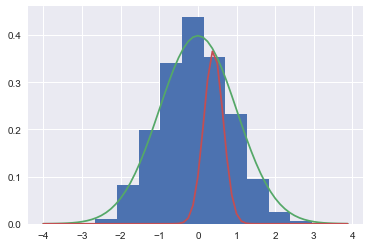

In [10]:
#visualizing the markov chain samples, after burn in.
#I show in green the distro we want to sample from
#I show in red the jump distribution used to create
#trial transitions
burnedin = Z[500:]
bin_counts=plt.hist(burnedin,normed=True)
X = np.arange(-4,4,0.125)
plt.plot(X,np.exp(-(X)**2/(2.))/np.sqrt(2.*np.pi))
plt.plot(X,np.exp(-(state-X)**2/(2.*trial_param**2))*np.exp(-(state)**2/(2.))/np.sqrt(2.*np.pi))
plt.show()

Now lets try to sample a Maxwell distribution using a normal-small variance proposal distribution 

In [11]:
# a helper function
def Indicator(x):
    if x < 0.:
        return 0.
    else:
        return 1.

# variance of the proposal distro
trial_param = 0.125;
# parameter for the maxwell distro
param = 0.76;
# hold the samples with an intial sample
Z = [1]

while len(Z) <= 10000:
    state = Z[-1] 
    # proposal sample from normal distro
    trial = state + trial_param*np.sqrt(-np.log(np.random.random()))*np.cos(2.*np.pi*np.random.random())
    
    # compute components of the acceptance crietera
    g_trial_state = np.exp(-(trial-state)**2/(2.*trial_param**2))/np.sqrt(2.*np.pi*trial_param**2) 
    p_trial = trial**2*np.exp(-trial**2/(2.*param))/np.sqrt(np.pi/2.*param**3)*Indicator(trial)
    
    g_state_trial = np.exp(-(state-trial)**2/(2.*trial_param**2))/np.sqrt(2.*np.pi*trial_param**2)
    p_state = 1/np.sqrt(np.pi/2.*param**3)*state**2*np.exp(-state**2/(2.*param))*Indicator(state)
    
    if np.random.random() <= (p_trial*g_state_trial)/(p_state*g_trial_state):
        Z.append(trial)

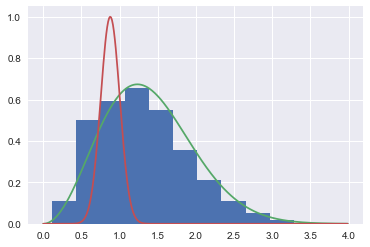

In [12]:
#visualizing the markov chain samples, after burn in.
#I show in green the distro we want to sample from
#I show in red the jump distribution used to create
#trial transitions
burnedin = Z[1000:]
bin_counts=plt.hist(burnedin,normed=True)
X = np.arange(0,4,0.0125)
plt.plot(X,X**2*np.exp(-X**2/(2.*param))/np.sqrt(np.pi/2.*param**3))
plt.plot(X,np.exp(-(state-X)**2/(2.*trial_param**2)))
plt.show()

so now we can see that by sampling from a designed transition matrix we can sample from any distribution simply by evaluating the distribution (or a function porportial to it!) at proposed sample points.  This is very valuable when the state space is large and the distribution is non-invertable. Classic examples include sampling in statistical mechanics for gases and other multiple degrees of freedom physical situations.  Several variations of the Metropolis-Hastings algo have been developed and are part of many scientists computational toolkit.